In [37]:
# import requests
# import bs4
# import re
# import pandas as pd
# import json
# import numpy as np
# from bs4 import BeautifulSoup
# # API 엔드포인트 URL
# url = f"https://www.jobplanet.co.kr/companies?sort_by=review_compensation_cache&industry_id={code}"

# # 요청 파라미터
# params = {
#     "page": 1,
#     "perPage": 10,
#     "serviceKey": API_KEY
# }

# # 요청 보내기
# response = requests.get(url, params=params)

# # 결과 출력
# if response.status_code == 200:
#     data = response.json()
#     print("✅ 요청 성공")
#     for item in data.get("data", []):
#         print(item)
# else:
#     print(f"❌ 요청 실패 (status: {response.status_code})")
#     print(response.text)

In [38]:
import requests
import bs4
import re
import pandas as pd
import json
import numpy as np
from bs4 import BeautifulSoup
file_path = 'data/'

# JSON 파일 불러오기
with open(file_path + 'PREFIX.json', 'r', encoding='utf-8') as f:
    PREFIX = json.load(f)
with open(file_path + 'SUFFIX.json', 'r', encoding='utf-8') as f:
    SUFFIX = json.load(f)


In [39]:

# 기존 구조: nested 딕셔너리 만들기
req_parameter_nested = {
    region: {
        district: PREFIX[region] + suffix[-3:]
        for district, suffix in districts.items()
    }
    for region, districts in SUFFIX.items()
}

# 평탄화(flatten) + 시단위 전체 지역 코드 추가
req_parameter = {}

for region, districts in req_parameter_nested.items():
    # 시 전체 ('서울') 코드: '강남구'처럼 직접 접근할 수 있도록
    if '전체' in districts:
        req_parameter[region] = districts['전체']  # ex) '서울': '101000'
    # 각 구/군도 추가
    for district, code in districts.items():
        req_parameter[district] = code

req_parameter2={
    '지역별':'domestic',
    '직업별':'job-category',
    '역세권별':'subway',
    'HOT100':'hot100',
    '헤드헌팅':'headhunting'
}


In [40]:
def parse_location_input(user_input):

    # 3. 지역명을 코드로 변환
    region_codes = []
    for region in user_input:
        code = req_parameter.get(region)
        if code:
            region_codes.append(code)
        else:
            print(f"경고: '{region}' 지역을 찾을 수 없습니다.")

    return "%2C".join(region_codes)  # URL 인코딩된 콤마

loc_cd_param = parse_location_input(['서울', '부산', '경기','인천','광주','대구','대전'])

In [41]:
job_link_list = []
corp_link_list = []
logo_list = []
title_list =[]
job_list = []
corp_list = []
local_list = []
exp_list = []
grad_list = []
date_list = []
badge_list = []
upload_list = []
for page in range(1,50):
    url = "https://www.saramin.co.kr/zf_user/jobs/list/{지역별}?page={page}&loc_cd={loc_cd_param}&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y".format(page=page, **req_parameter2, loc_cd_param=loc_cd_param)
    print(url)
    req_header = {
        'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36'
    }

    res = requests.get(url, headers = req_header)
    res.encoding = 'utf-8'

    
    if res.ok:
        html = res.text
        soup = BeautifulSoup(html, 'html.parser') 
        # CSS 선택자
        a_tag_list = soup.select("div#default_list_wrap div.list_body div.box_item")
        # <a> 태그 리스트 순회하기    
        for a_tag in a_tag_list:
            # 링크
            job_link_dict = {}
            if a_tag.find("div", class_ ="job_tit").find("a", class_ = "str_tit") == None:
                print(a_tag.find("div", class_ ="job_tit"))
                job_link_dict['링크'] = 'NULL'
            else:
                job_link_dict['링크'] = "https://www.saramin.co.kr" + a_tag.find("div", class_ ="job_tit").find("a", class_ = "str_tit")['href']
            job_link_list.append(job_link_dict)

            # 회사 링크
            corp_link_dict = {}
            if a_tag.find("div", class_ ="col company_nm").find("a", class_ = "str_tit") == None:
                corp_link_dict['회사링크'] = 'NULL'
            else:
                corp_link_dict['회사링크'] = "https://www.saramin.co.kr" + a_tag.find("div", class_ ="col company_nm").find("a", class_ = "str_tit")['href']
            corp_link_list.append(corp_link_dict)

            # 로고
            # logo_dict = {}
            # if len(a_tag.select("span.logo img[src*='banner_logo/company/logo_banner/']")) == 0:
            #     logo_dict['로고'] = 'Null'
            # else:
            #     img_url = a_tag.select("span.logo img[src*='banner_logo/company/logo_banner/']")
            #     logo_dict['로고'] = img_url[0]['src']
            # logo_list.append(logo_dict)

            # 제목
            title_dict = {}
            if len(a_tag.find("div", class_ ="col notification_info").find("div", class_ = "job_tit").select("span")) == 0:
                title_dict['제목'] = 'Null'
            else:
                title = a_tag.find("div", class_ ="col notification_info").find("div", class_ = "job_tit").select("span")[0].text
                title_dict['제목'] = title
            title_list.append(title_dict)

            # 회사
            corp_dict = {}
            if len(a_tag.find("div", class_ ="col company_nm").find(class_ = "str_tit")) == 0:
                corp_dict['회사'] = 'Null'
            else:
                corp = a_tag.find("div", class_ ="col company_nm").find(class_ = "str_tit").text
                corp_dict['회사'] = corp
            corp_list.append(corp_dict)
            clean_corp = []
            for item in corp_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_corp.append(clean_item)
            
            # 직무
            job_dict = {}
            job = a_tag.select_one('.job_sector')
            if len(job) == 0:
                job_dict['직무'] = 'Null'
            else:
                jobs = [span.get_text(strip=True).replace('::before', '').strip() for span in job.find_all('span')]
                job_dict['직무'] = jobs
            job_list.append(job_dict)
            
            # 지역, 경력, 학력
            temp = a_tag.find("div", class_ = "col recruit_info")
            local_dict = {}
            exp_dict = {}
            grad_dict = {}
            if len(temp) >= 3:
                local_dict['지역'] = temp.find("p", class_ = "work_place").text
                exp_dict['요구경력'] = temp.find("p", class_ = "career").text
                grad_dict['최소학력'] = temp.find("p", class_ = "education").text
            else:
                local_dict['지역'] = 'NULL'
                exp_dict['요구경력'] = 'NULL'
                grad_dict['최소학력'] = 'NULL'
            local_list.append(local_dict)
            exp_list.append(exp_dict)
            grad_list.append(grad_dict)

            for region in local_list:
                if region['지역'].endswith(' 외'):
                    region['지역'] = region['지역'][:-2]

            # 기간
            date_dict = {}
            if len(a_tag.select("span.date")) == 0:
                date_dict['기간'] = 'Null'
            else:
                date = a_tag.select("span.date")[0].text
                date_dict['기간'] = date
            date_list.append(date_dict)

            clean_date = []
            for item in date_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_date.append(clean_item)

            # 등록일자
            upload_dict = {}
            if len(a_tag.select_one("span.deadlines")) == 0:
                upload_dict['등록일자'] = 'Null'
            else:
                upload = a_tag.select("span.deadlines")[0].text
                upload_dict['등록일자'] = upload
            upload_list.append(upload_dict)

            # 배지
            badge_dict = {}
            if a_tag.select_one(".job_badge") == None:
                badge_dict['배지'] = 'Null'
            else:
                badge = a_tag.select_one(".job_badge").find("span").text
                badge_dict['배지'] = badge
            badge_list.append(badge_dict)
            clean_badge = []
            for item in badge_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_badge.append(clean_item)

    else:
        # 응답(response)이 Error 이면 status code 출력    
        print(f'에러 코드 1= {res.status_code}')


https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=1&loc_cd=101000%2C106000%2C102000%2C108000%2C103000%2C104000%2C105000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=2&loc_cd=101000%2C106000%2C102000%2C108000%2C103000%2C104000%2C105000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=3&loc_cd=101000%2C106000%2C102000%2C108000%2C103000%2C104000%2C105000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=4&loc_cd=101000%2C106000%2C102000%2C108000%2C103000%2C104000%2C105000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=5&loc_cd=101000%2C106000%2C102000%2C108000%2C103000%2C104000%2C105000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&previ

In [42]:

combined_list = []
for link, corp_link, title, corp, job, local, exp, grad, date, upload, badge in zip(job_link_list, corp_link_list,title_list, clean_corp, job_list, local_list, exp_list, grad_list, clean_date, upload_list, clean_badge):
    merged_dict = {}
    merged_dict.update(link)
    merged_dict.update(corp_link)
    merged_dict.update(title)
    merged_dict.update(corp)
    merged_dict.update(job)
    merged_dict.update(local)
    merged_dict.update(exp)
    merged_dict.update(grad)
    merged_dict.update(date)
    merged_dict.update(upload)
    merged_dict.update(badge)
    combined_list.append(merged_dict)



In [43]:

# DataFrame으로 변환
df = pd.DataFrame(combined_list)
print(job_link_list)
df.head()

[{'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50532559&adsCategoryItem=effect_bold&'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50507697'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50534810'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50357430'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50440648'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50337992'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50491295'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50382020'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50402224'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50368357'}, {'링크': 'https://www.saramin.co.kr/zf_use

,링크,회사링크,제목,회사,직무,지역,요구경력,최소학력,기간,등록일자,배지
0,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[스마틱스] 재무팀 팀장 채용,(주)스마틱스,"[연결회계, IFRS, 경영지원, 인사]",서울 영등포구,경력 10년↑ · 정규직,대학교(4년)↑,~05.17(토),3일 전 등록,회계·세무·재무 스크랩 급상승
1,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,식생활교육국민네트워크 각 부문 신입 직원 채용,(사)식생활교육국민네트워크,[사업기획],경기 수원시 팔달구,경력무관 · 정규직,학력무관,채용시,5일 전 등록,인기있는
2,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[홍대 올라인의원] 일본 상담실장 추가 채용 공고(경력),올라인의원,[상담실장],서울 마포구,경력 1년↑ · 정규직 외,학력무관,~05.17(토),3일 전 등록,Null
3,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,현대카드 탈회문의고객 대상 인바운드 상담 모집,티엠파크,"[사무직, 내방객응대, 사무보조, 사이트관리, 자료입력]",서울 강서구,경력무관 · 정규직 외,고졸↑,D-6,4분 전 수정,Null
4,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,농협은행 고객센터 대표번호 인바운드 상담 모집,티엠파크,"[사무직, 문서작성, 사무보조, 자료입력, 자료조사]",광주 광산구,경력무관 · 정규직 외,고졸↑,~05.08(목),4분 전 수정,Null


In [44]:
# '원문' 열 만들기 (기존 요구경력 복사)
df['원문'] = df['요구경력']

def split_info(text):
    if not isinstance(text, str):
        return pd.Series([None, None])
    
    parts = re.split(r'\s*·\s*', text)

    if len(parts) >= 2:
        exp = ' · '.join(parts[:-1]).strip()
        job_type = re.sub(r'\s*외$', '', parts[-1].strip())
        return pd.Series([exp, job_type])
    else:
        return pd.Series([text.strip(), None])
    
# 위에서 고친 split_info 함수 적용
df[['요구경력_raw', '계약종류']] = df['원문'].apply(split_info)

# 문자열 확인 추가된 normalize 함수
def normalize_experience(exp):
    if not isinstance(exp, str):
        return None  # 또는 '기타', '불명' 등

    exp = exp.strip()
    if '신입' in exp and '경력' in exp:
        return '신입/경력'
    elif '신입' in exp:
        return '신입'
    elif '경력무관' in exp or '년수무관' in exp:
        return '경력무관'
    elif re.match(r'경력 \d+년↑', exp):
        years = re.findall(r'\d+', exp)[0]
        return f'{years}년 이상'
    elif re.match(r'경력 \d+년↓', exp):
        years = re.findall(r'\d+', exp)[0]
        return f'{years}년 이하'
    elif re.match(r'\d+ ~ \d+년', exp):
        return exp.replace(' ', '')
    elif exp == '경력':
        return '경력'
    else:
        return exp

# 적용
df['요구경력'] = df['요구경력_raw'].apply(normalize_experience)
df.drop(columns=['요구경력_raw'], inplace=True)
df['계약종류'].unique()

array(['정규직', '계약직', '프리랜서', '위촉직', '전임', '교육생', '파견직', None, '인턴직', '경력',
       '파트', '아르바이트', '병역특례'], dtype=object)

In [45]:
df['등록일자'].unique()

array(['3일 전 등록', '5일 전 등록', '4분 전 수정', '5분 전 수정', '4일 전 등록', '6분 전 수정',
       '7분 전 수정', '10분 전 수정', '27일 전 등록', '18일 전 등록', '9일 전 등록',
       '2일 전 등록', '14분 전 수정', '11일 전 등록', '1일 전 등록', '10일 전 등록',
       '110일 전 등록', '55일 전 등록', '47일 전 등록', '46일 전 등록', '32일 전 등록',
       '30일 전 등록', '45일 전 등록', '26일 전 등록', '24일 전 등록', '20일 전 등록',
       '19일 전 등록', '17일 전 등록', '16일 전 등록', '13일 전 등록', '12일 전 등록',
       '6일 전 등록', '20분 전 수정', '66일 전 등록', '34일 전 등록', '2시간 전 수정',
       '23일 전 등록', '40일 전 등록', '54일 전 등록', '39일 전 등록', '31일 전 등록',
       '62일 전 등록', '37일 전 등록', '108일 전 등록', '38일 전 등록', '153일 전 등록',
       '41일 전 등록', '25일 전 등록', '31분 전 수정', '32분 전 수정', '541일 전 등록',
       '36분 전 수정', '48분 전 수정', '1시간 전 수정', '297일 전 등록', '61일 전 등록',
       '9시간 전 수정', '53일 전 등록', '33일 전 등록', '233일 전 등록', '257일 전 등록',
       '548일 전 등록', '2시간 전 등록', '21일 전 등록', '7일 전 등록', '8일 전 등록',
       '59일 전 등록', '44일 전 등록', '3시간 전 수정', '3시간 전 등록', '57일 전 등록',
       '52일 전 등록', '150일 전 등록', '58일 전 등록', '51일 전 등록',

In [46]:
import re

def process_registration_date(text):
    if not isinstance(text, str):
        return None
    
    # '수정'과 '등록' 제거
    text = re.sub(r'\s*(수정|등록)\s*', '', text)
    
    # 'n시간 전'을 '당일'로 변경
    text = re.sub(r'\d+\s*시간\s*전', '당일', text)
    
    # 'n분 전'은 그대로 두기
    text = re.sub(r'\d+\s*분\s*전', '당일', text)
    
    return text.strip()

# 적용
df['등록일자'] = df['등록일자'].apply(process_registration_date)

In [47]:
df['등록일자'].unique()

array(['3일 전', '5일 전', '당일', '4일 전', '27일 전', '18일 전', '9일 전', '2일 전',
       '11일 전', '1일 전', '10일 전', '110일 전', '55일 전', '47일 전', '46일 전',
       '32일 전', '30일 전', '45일 전', '26일 전', '24일 전', '20일 전', '19일 전',
       '17일 전', '16일 전', '13일 전', '12일 전', '6일 전', '66일 전', '34일 전',
       '23일 전', '40일 전', '54일 전', '39일 전', '31일 전', '62일 전', '37일 전',
       '108일 전', '38일 전', '153일 전', '41일 전', '25일 전', '541일 전', '297일 전',
       '61일 전', '53일 전', '33일 전', '233일 전', '257일 전', '548일 전', '21일 전',
       '7일 전', '8일 전', '59일 전', '44일 전', '57일 전', '52일 전', '150일 전',
       '58일 전', '51일 전', '48일 전', '15일 전', '28일 전'], dtype=object)

In [48]:
df['기간'].unique()

array(['~05.17(토)', '채용시', 'D-6', '~05.08(목)', 'D-4', '~05.13(화)',
       '~05.01(목)', '~05.03(토)', '~04.30(수)', '~05.05(월)', '~05.16(금)',
       '~05.11(일)', '~05.04(일)', 'D-2', 'D-7', '~05.12(월)', '~05.09(금)',
       '~05.19(월)', '~06.08(일)', '~04.29(화)', '~05.20(화)', '~05.07(수)',
       '내일마감', '~05.06(화)', '~05.14(수)', '~05.02(금)', '오늘마감', 'D-3',
       '상시채용', '~05.18(일)', '~05.15(목)', '~05.31(토)', '~06.16(월)',
       '~06.25(수)', '~06.19(목)', '~05.10(토)', 'D-5', '~06.14(토)',
       '~06.10(화)', '~06.13(금)', '~06.09(월)', '~06.06(금)', '~06.17(화)',
       '~05.24(토)', '~05.25(일)', '~06.27(금)', '~07.06(일)', '~06.18(수)',
       '~05.27(화)', '22시 마감', '10시 마감', '~06.01(일)', '~06.26(목)',
       '~06.03(화)', '~05.21(수)', '~05.29(목)', '~05.23(금)', '~06.04(수)',
       '~06.02(월)', '~05.30(금)', '~06.15(일)', '~05.26(월)', '~06.07(토)',
       '~07.15(화)', '18시 마감', '~06.11(수)'], dtype=object)

In [49]:
df.head()

,링크,회사링크,제목,회사,직무,지역,요구경력,최소학력,기간,등록일자,배지,원문,계약종류
0,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[스마틱스] 재무팀 팀장 채용,(주)스마틱스,"[연결회계, IFRS, 경영지원, 인사]",서울 영등포구,10년 이상,대학교(4년)↑,~05.17(토),3일 전,회계·세무·재무 스크랩 급상승,경력 10년↑ · 정규직,정규직
1,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,식생활교육국민네트워크 각 부문 신입 직원 채용,(사)식생활교육국민네트워크,[사업기획],경기 수원시 팔달구,경력무관,학력무관,채용시,5일 전,인기있는,경력무관 · 정규직,정규직
2,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[홍대 올라인의원] 일본 상담실장 추가 채용 공고(경력),올라인의원,[상담실장],서울 마포구,1년 이상,학력무관,~05.17(토),3일 전,Null,경력 1년↑ · 정규직 외,정규직
3,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,현대카드 탈회문의고객 대상 인바운드 상담 모집,티엠파크,"[사무직, 내방객응대, 사무보조, 사이트관리, 자료입력]",서울 강서구,경력무관,고졸↑,D-6,당일,Null,경력무관 · 정규직 외,정규직
4,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,농협은행 고객센터 대표번호 인바운드 상담 모집,티엠파크,"[사무직, 문서작성, 사무보조, 자료입력, 자료조사]",광주 광산구,경력무관,고졸↑,~05.08(목),당일,Null,경력무관 · 정규직 외,정규직


In [50]:
df.replace("NULL", np.nan, inplace=True)
for i in df.columns :
    missingValueRate = df[i].isna().sum() / len(df) * 100
    if missingValueRate > 0 :
        print("{} 결측치 비율: {}%".format(i,round(missingValueRate, 2)))

회사링크 결측치 비율: 5.88%
계약종류 결측치 비율: 0.04%


In [51]:
temp = []
for jobs in df['직무']:
    for job in jobs:
        temp.append(job)
print(set(temp))

{'콘텐츠기획', 'IR/공시', '유통MD', 'DBA', '처치실', '토목공사', '파티플래너', '게임디자인', 'E/N', '에칭', '서류관리', '바리스타', '지배인', '웨딩홀', 'TTS', 'ER(노무관리)', '샵마스터', '변호사', '행사기획', '원자력', '사업기획', '회원관리', '충진', '교환/반품', '장비설계', '도면해독', '반송설비', 'MC', 'Java', '테크니컬라이터', '영선', '시설관리', '솔리드웍스', '공간디자인', 'ASP.NET', '호텔', '직업훈련', '치과', '주차요원', '요리사', '더존', '이벤트운영', '작업치료사', 'B2B마케팅', '데이터시각화', '설비보수', '식품연구', '공인회계사', '물리치료사', '도시교통', '칭량', '크로스브라우징', 'CRC(연구간호사)', '사회조사', '메카트로닉스', '세무조정', '마케팅전략', '포토그래퍼', '손익관리', 'AD(아트디렉터)', '자율주행', '학술연구', 'CISO', '인디자인', '컴퓨터비전', '간호조무사', '리빙', '산업디자인', '콘서트', '인공신장실', '코딩', '미화원', 'C언어', '교구수업', '패션잡화', '디지털마케팅', '물리', '게시판관리', '품질보증', 'OA', '유기합성', '국제무역사', '언어치료사', '치과위생사', 'IPO', '패션MD', '여성의원', '대출심사', 'RA', '전기용접', '박물관', '가사도우미', '농구', '병원코디네이터', '기술상담', '안전관리자', '생산', '트러블슈팅', '캐드원', '사내행사', 'AM(어카운트매니저)', '프론트', 'Excel', '보안컨설팅', 'CW(카피라이터)', 'Spring', '미술', '인플루언서', '메이크업', '경비지도사', '개발구매', '영화기획', '보건의료정보관리사', 'MDD', '2.5톤', '마취간호사', '구급차기사', '배송기사', '교육상담', '잡화판매', '수질분

In [52]:
df.shape

(2450, 13)

In [53]:

df.dropna(axis = 0, inplace=True)
df.shape

(2305, 13)

In [54]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

font_path = 'C:\\windows\\Fonts\\malgun.ttf'
font_prop = fm.FontProperties(fname=font_path).get_name()


matplotlib.rc('font', family=font_prop)

In [55]:
dev_df = df[df['제목'].str.contains('개발', na=False)]

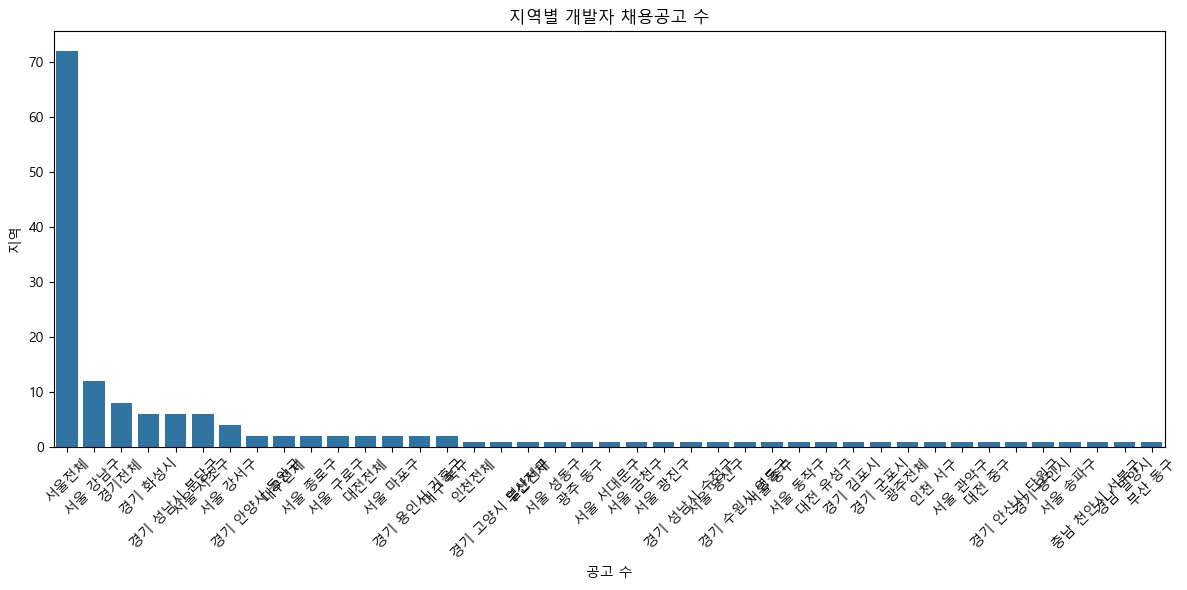

In [56]:

# 지역별 공고 수
plt.figure(figsize=(12, 6))
sns.countplot(data=dev_df, x='지역', order=dev_df['지역'].value_counts().index)
plt.title('지역별 개발자 채용공고 수')
plt.xlabel('공고 수')
plt.ylabel('지역')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

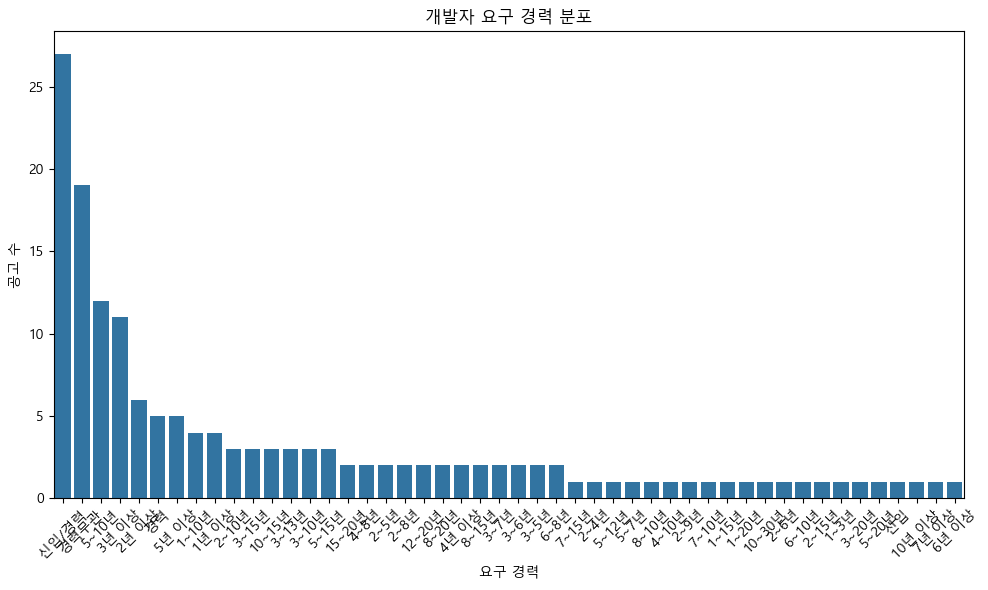

In [57]:
plt.figure(figsize=(10, 6))
sns.countplot(data=dev_df, x='요구경력', order=dev_df['요구경력'].value_counts().index)
plt.title('개발자 요구 경력 분포')
plt.xlabel('요구 경력')
plt.ylabel('공고 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

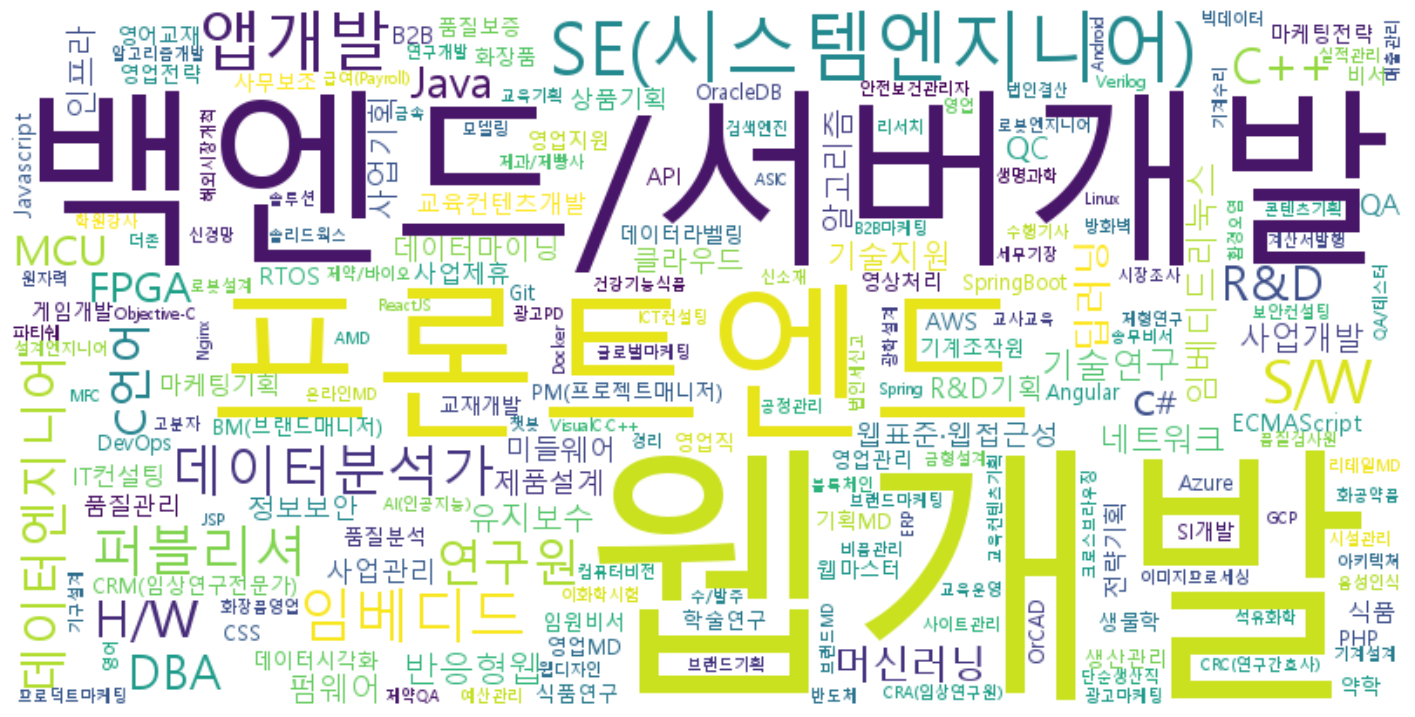

In [61]:
from wordcloud import WordCloud
dev_df['직무'].loc()
df_exploded = dev_df.explode('직무')
df_exploded
job_counts = df_exploded['직무'].value_counts()

wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white', colormap='viridis')
wordcloud.generate_from_frequencies(job_counts.to_dict())

plt.figure(figsize=(18, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
# df_exploded['직무'].unique()

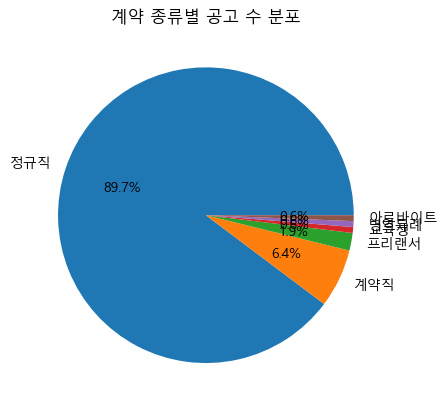

In [59]:
contract_counts = dev_df['계약종류'].value_counts()

contract_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('계약 종류별 공고 수 분포')
plt.ylabel('')
plt.show()

In [60]:
df.loc[df['회사'] == df['회사'].unique()]

ValueError: ('Lengths must match to compare', (2305,), (1579,))

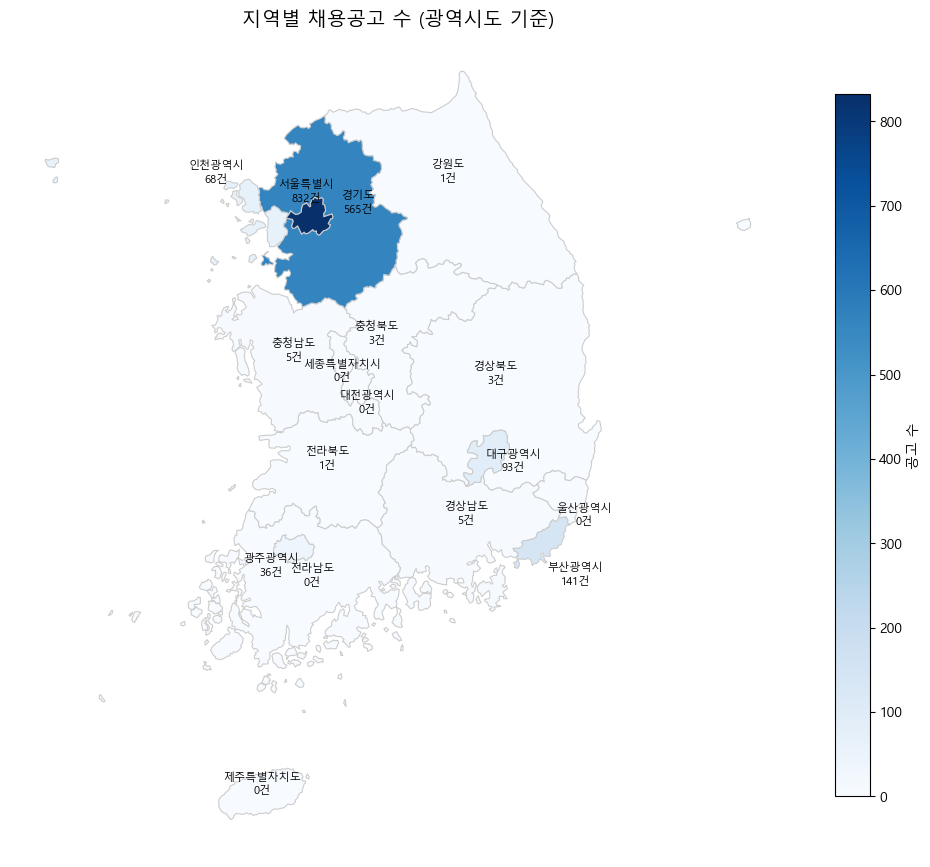

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 1. 지역명을 광역시/도로 변환하는 함수
def convert_region(name):
    if name == '전국':
        return None
    parts = name.split()
    region_map = {
        '서울': '서울특별시', '부산': '부산광역시', '대구': '대구광역시',
        '인천': '인천광역시', '광주': '광주광역시', '대전': '대전광역시',
        '울산': '울산광역시', '세종': '세종특별자치시', '경기': '경기도',
        '강원': '강원도', '충북': '충청북도', '충남': '충청남도',
        '전북': '전라북도', '전남': '전라남도', '경북': '경상북도',
        '경남': '경상남도', '제주': '제주특별자치도'
    }
    return region_map.get(parts[0], None)

# 2. 필터된 데이터프레임에 광역시도 열 추가
filtered_df = df[df['지역'] != '서울전체'].copy() 
filtered_df['광역시도'] = filtered_df['지역'].apply(convert_region)

# 3. 지역별 공고 수 집계
region_counts = filtered_df['광역시도'].value_counts().reset_index()
region_counts.columns = ['지역', '공고수']

# 4. GeoJSON 파일 불러오기
gdf = gpd.read_file('data/skorea_provinces_geo_simple.json')

# 5. 병합 (left join으로 모든 지역 유지)
merged = gdf.merge(region_counts, left_on='name', right_on='지역', how='left')
merged['공고수'] = merged['공고수'].fillna(0).astype(int)

# 6. 일부 지역의 라벨이 겹치지 않도록 위치 보정값 정의
label_offsets = {
    '서울특별시': (0, 0.1),
    '세종특별자치시': (0, -0.2),
    '인천광역시': (-0.3, 0.1),
    '대전광역시': (0.1, -0.2),
    '광주광역시': (-0.2, -0.2),
    '대구광역시': (0.2, -0.1),
    '부산광역시': (0.3, -0.3),
    '울산광역시': (0.2, -0.2),
}

# 7. 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
merged.plot(
    column='공고수',
    cmap='Blues',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'shrink': 0.6, 'label': '공고 수'}
)

# 8. 지도 위에 텍스트 표시 (지역명 + 공고수)
for idx, row in merged.iterrows():
    point = row.geometry.representative_point()
    dx, dy = label_offsets.get(row['name'], (0, 0))
    plt.annotate(
        text=f"{row['name']}\n{row['공고수']}건",
        xy=(point.x + dx, point.y + dy),
        ha='center',
        fontsize=8,
        color='black'
    )

plt.title('지역별 채용공고 수 (광역시도 기준)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()
